# Analysis of World-happiness-report-updated_2024.csv

Importing libraries and reading csv data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("data.csv", encoding="latin1")
df.columns = df.columns.str.lower().str.replace(" ","_")

df.head(10)

,country_name,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   life_ladder                       2363 non-null   float64
 3   log_gdp_per_capita                2335 non-null   float64
 4   social_support                    2350 non-null   float64
 5   healthy_life_expectancy_at_birth  2300 non-null   float64
 6   freedom_to_make_life_choices      2327 non-null   float64
 7   generosity                        2282 non-null   float64
 8   perceptions_of_corruption         2238 non-null   float64
 9   positive_affect                   2339 non-null   float64
 10  negative_affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB
None


Checking the empty data and starting the cleaning.

I deleted the rows with least empty values because of two reasons: 

Reason #1: They werent likely to affect the results because how small their proportion is.

Reason #2: We cant do interpolation or data imputation because they werent continuous numerical measurement data but survey based responses.

country_name                          0
year                                  0
life_ladder                           0
social_support                       13
negative_affect                      16
positive_affect                      24
log_gdp_per_capita                   28
freedom_to_make_life_choices         36
healthy_life_expectancy_at_birth     63
generosity                           81
perceptions_of_corruption           125
dtype: int64


Percentages: 
country_name                        0.000000
year                                0.000000
life_ladder                         0.000000
social_support                      0.550148
negative_affect                     0.677105
positive_affect                     1.015658
log_gdp_per_capita                  1.184934
freedom_to_make_life_choices        1.523487
healthy_life_expectancy_at_birth    2.666102
generosity                          3.427846
perceptions_of_corruption           5.289886
dtype: float64


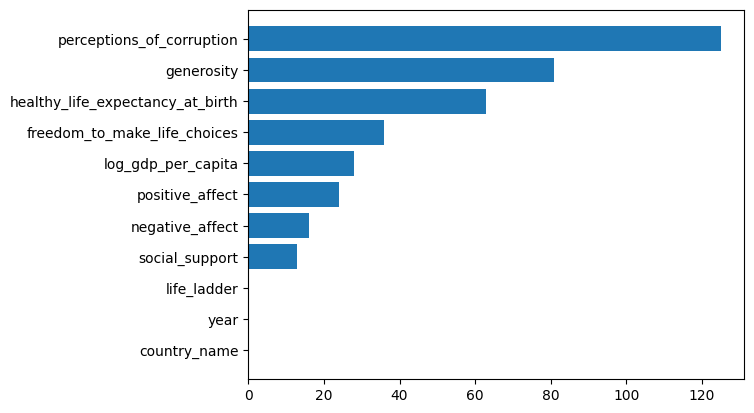

In [28]:
p = df.isna().sum()
p = p.sort_values()
print(p)
print(f"\n\nPercentages: \n{df.isna().mean().sort_values() * 100}")

df = df.dropna(subset=["social_support", "negative_affect", "positive_affect"])
row_count_df = df.country_name.value_counts(dropna=False)

plt.barh(p.index, p)
plt.show()


Since columns Log GDP per capita, Freedom to make life choices and Healthy life expectancy at birth are time dependent numerical measurements/computations so per country interpolation for each row with empty data is better here.

country_name                          0
year                                  0
life_ladder                           0
log_gdp_per_capita                    0
social_support                        0
healthy_life_expectancy_at_birth      0
freedom_to_make_life_choices          0
generosity                           73
perceptions_of_corruption           113
positive_affect                       0
negative_affect                       0
dtype: int64


Percentages: 
country_name                        0.000000
year                                0.000000
life_ladder                         0.000000
log_gdp_per_capita                  0.000000
social_support                      0.000000
healthy_life_expectancy_at_birth    0.000000
freedom_to_make_life_choices        0.000000
positive_affect                     0.000000
negative_affect                     0.000000
generosity                          3.126338
perceptions_of_corruption           4.839400
dtype: float64


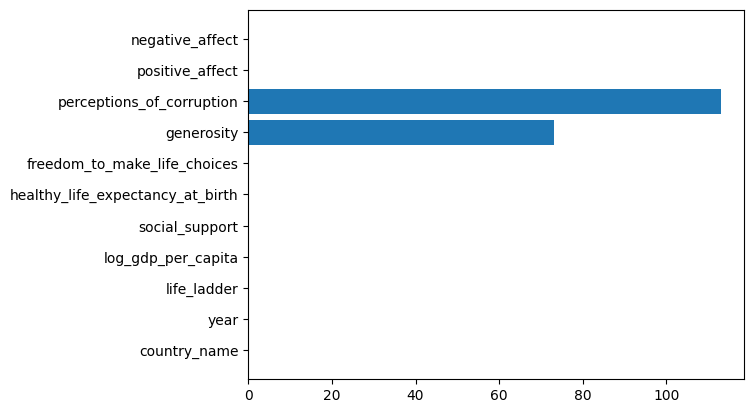

In [29]:
df = df.sort_values(["country_name", "year"])

cols_interp = [
    "log_gdp_per_capita",
    "freedom_to_make_life_choices",
    "healthy_life_expectancy_at_birth"
]

df[cols_interp] = (df.groupby("country_name")[cols_interp].transform(lambda x: x.interpolate(method="linear", limit_direction="both")))
df[cols_interp] = df[cols_interp].fillna(df[cols_interp].mean())

p = df.isna().sum()
print(p)
print(f"\n\nPercentages: \n{df.isna().mean().sort_values() * 100}")
plt.barh(p.index, p)
plt.show()

Assumimg countries with similar happiness/GDP scores likely have similar corruption levels. KNN assigns a new data point to the majority set within its neighbors.

In [30]:
imputer = KNNImputer(n_neighbors=5)
cols_interp = ["generosity", "perceptions_of_corruption"]

df_ = df[cols_interp]
df_ = imputer.fit_transform(df_)
df[cols_interp] = pd.DataFrame(df_, columns=cols_interp, index=df.index)

p = df.isna().sum()
print(p)
print(f"\n\nPercentages: \n{df.isna().mean().sort_values() * 100}")

country_name                        0
year                                0
life_ladder                         0
log_gdp_per_capita                  0
social_support                      0
healthy_life_expectancy_at_birth    0
freedom_to_make_life_choices        0
generosity                          0
perceptions_of_corruption           0
positive_affect                     0
negative_affect                     0
dtype: int64


Percentages: 
country_name                        0.0
year                                0.0
life_ladder                         0.0
log_gdp_per_capita                  0.0
social_support                      0.0
healthy_life_expectancy_at_birth    0.0
freedom_to_make_life_choices        0.0
generosity                          0.0
perceptions_of_corruption           0.0
positive_affect                     0.0
negative_affect                     0.0
dtype: float64


After we handled all missing data situation, here is a chart to see how many rows of data for each country (im not sure about what that error suppose to mean):

d:\projects\asil\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


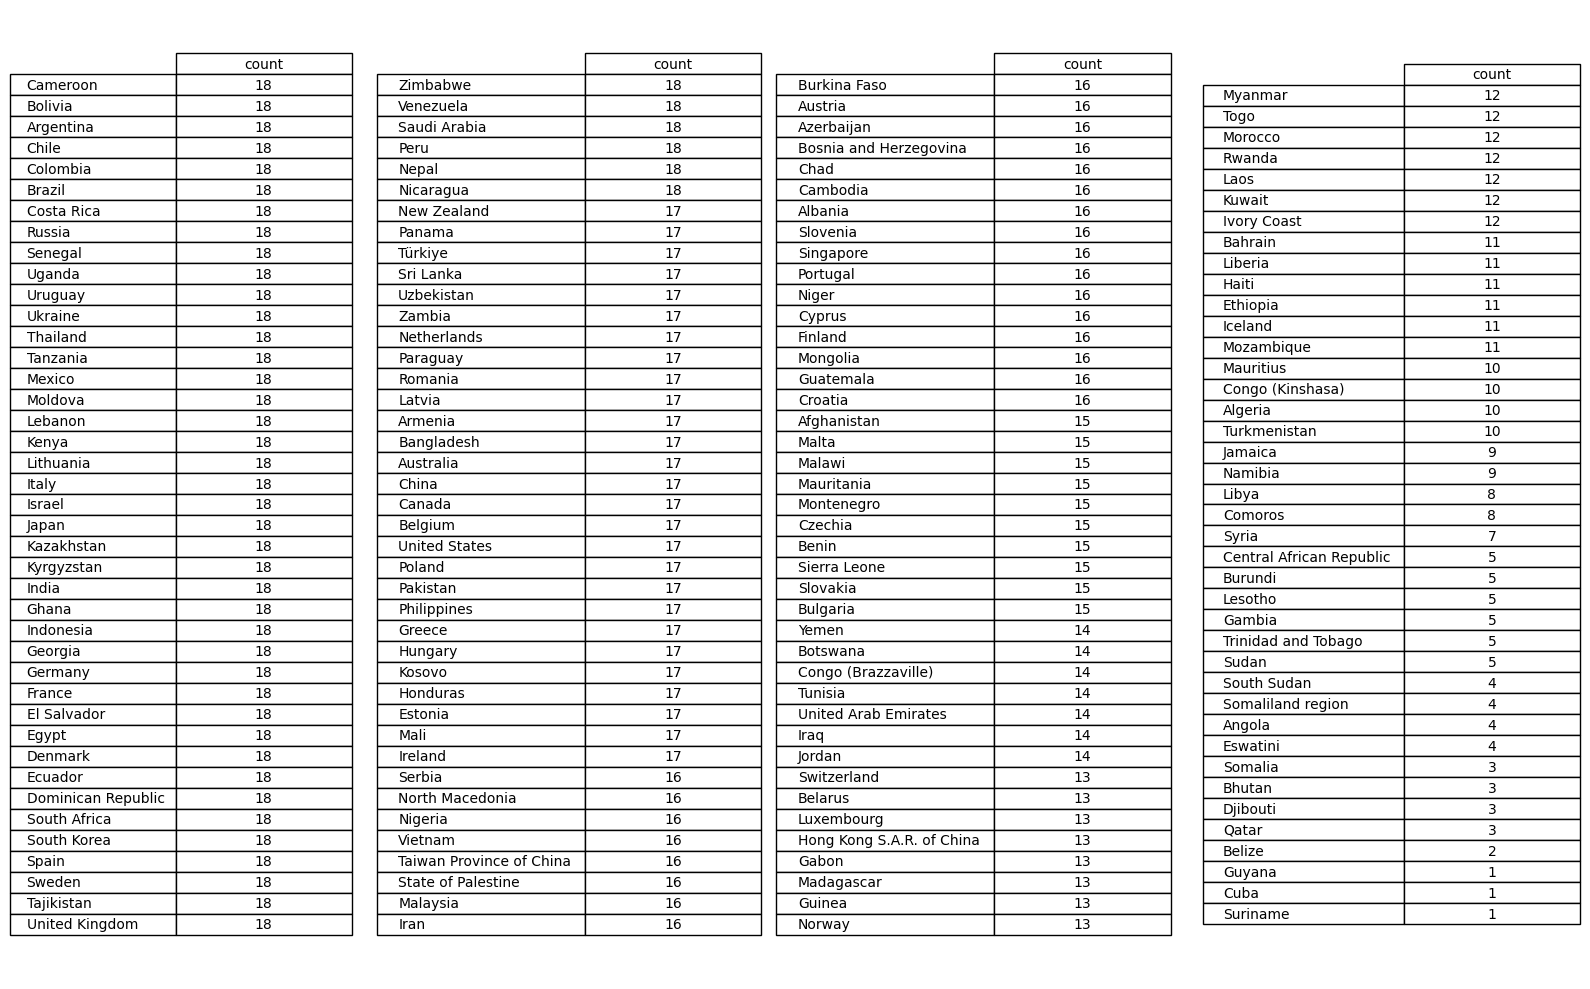

In [31]:
n_cols = 4
chunks = np.array_split(row_count_df, n_cols)

fig, axes = plt.subplots(1, n_cols, figsize=(16, 10)) 

for i, chunk in enumerate(chunks):
    ax = axes[i]
    ax.axis("off")
    
    table = pd.plotting.table(ax, chunk, loc="center", cellLoc="center")

plt.tight_layout()
plt.show()

Checking the data

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,2335.0,2014.806424,5.051089,2005.000,2011.000,2015.000,2019.0000,2023.000
life_ladder,2335.0,5.484140,1.126639,1.281,4.647,5.451,6.3235,8.019
log_gdp_per_capita,2335.0,9.391299,1.162615,5.527,8.504,9.498,10.3900,11.676
social_support,2335.0,0.809576,0.121313,0.228,0.744,0.835,0.9040,0.987
healthy_life_expectancy_at_birth,2335.0,63.428057,6.790525,6.720,59.490,65.000,68.5600,74.600
freedom_to_make_life_choices,2335.0,0.750375,0.139750,0.228,0.661,0.772,0.8620,0.985
generosity,2335.0,0.000709,0.159444,-0.340,-0.108,-0.020,0.0920,0.700
perceptions_of_corruption,2335.0,0.743834,0.182003,0.035,0.687,0.797,0.8650,0.983
positive_affect,2335.0,0.651798,0.106175,0.179,0.572,0.663,0.7370,0.884
negative_affect,2335.0,0.273077,0.087114,0.083,0.209,0.262,0.3260,0.705


Checking Outliers:

Because this data does not have to be normally distributed, i chose not to remove outliers. 

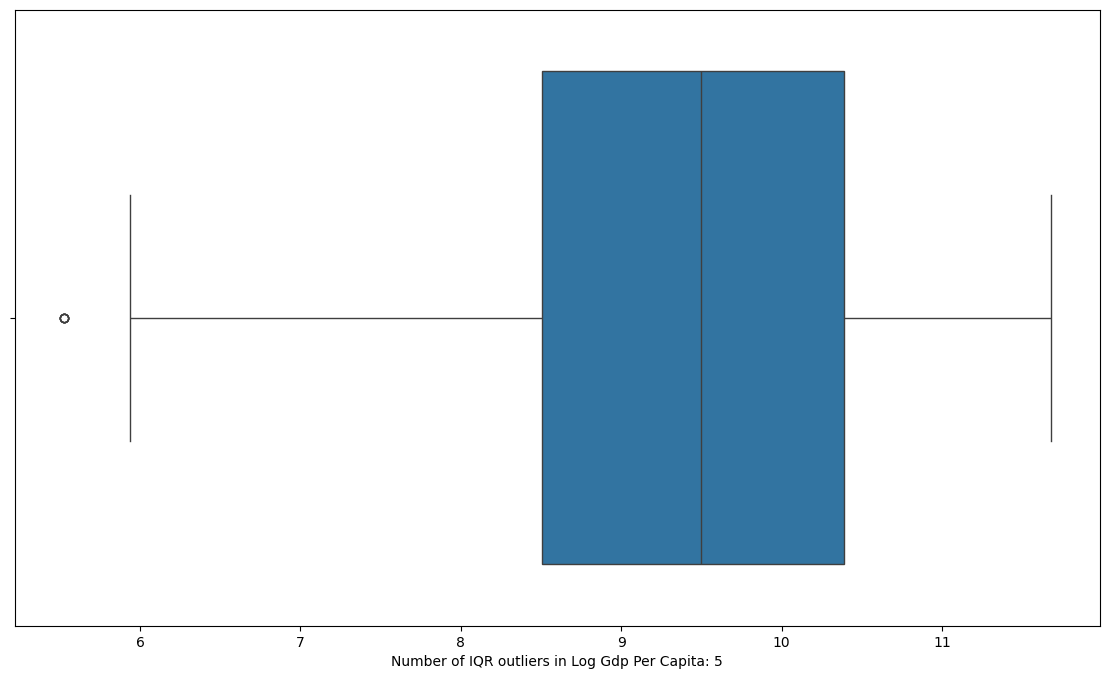

In [33]:
criteria = df.log_gdp_per_capita

q1 = criteria.quantile(0.25)
q3 = criteria.quantile(0.75)
iqr = q3 - q1

outliers = df[(criteria < q1 - 1.5*iqr) | (criteria > q3 + 1.5*iqr)]
plt.figure(figsize=(14,8))
sns.boxplot(x=criteria)
plt.xlabel(f"Number of IQR outliers in {str(criteria.name).replace("_", " ").title()}: {outliers.shape[0]}")
plt.show()


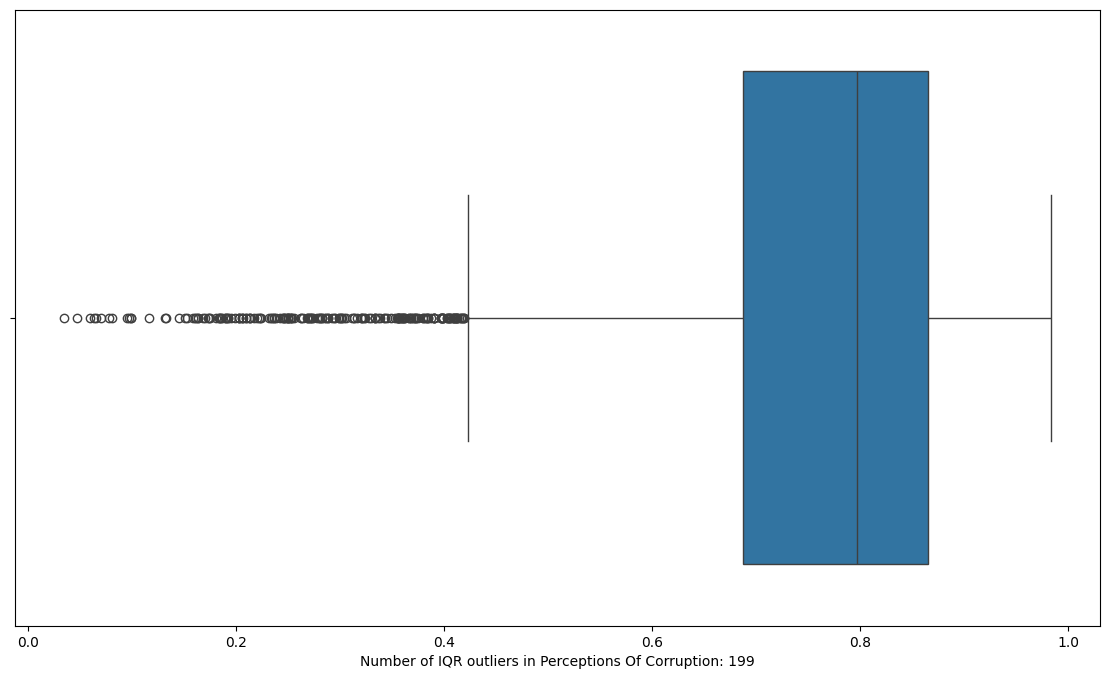

In [34]:
criteria = df.perceptions_of_corruption

q1 = criteria.quantile(0.25)
q3 = criteria.quantile(0.75)
iqr = q3 - q1

outliers = df[(criteria < q1 - 1.5*iqr) | (criteria > q3 + 1.5*iqr)]
plt.figure(figsize=(14,8))
sns.boxplot(x=criteria)
plt.xlabel(f"Number of IQR outliers in {str(criteria.name).replace("_", " ").title()}: {outliers.shape[0]}")
plt.show()


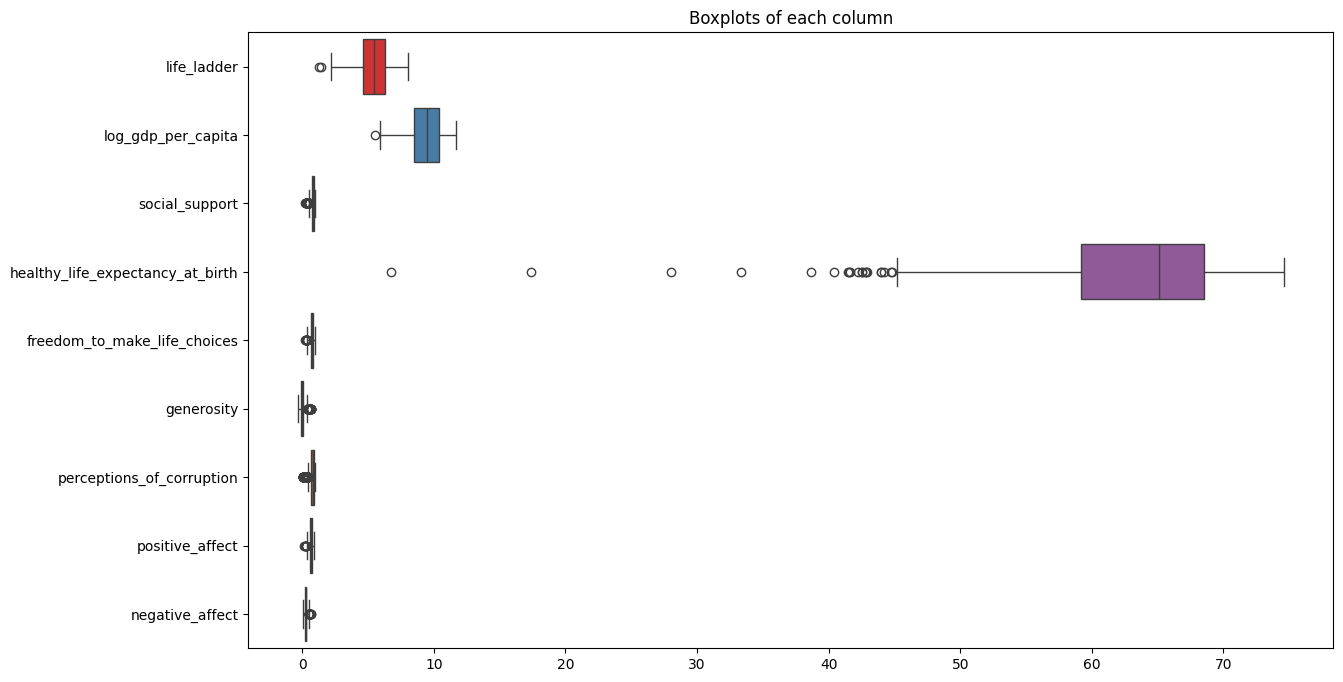

In [60]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df.drop("year", axis = 1),orient="h", palette = "Set1" )
plt.title("Boxplots of each column")
plt.show()

To better see outliers: 

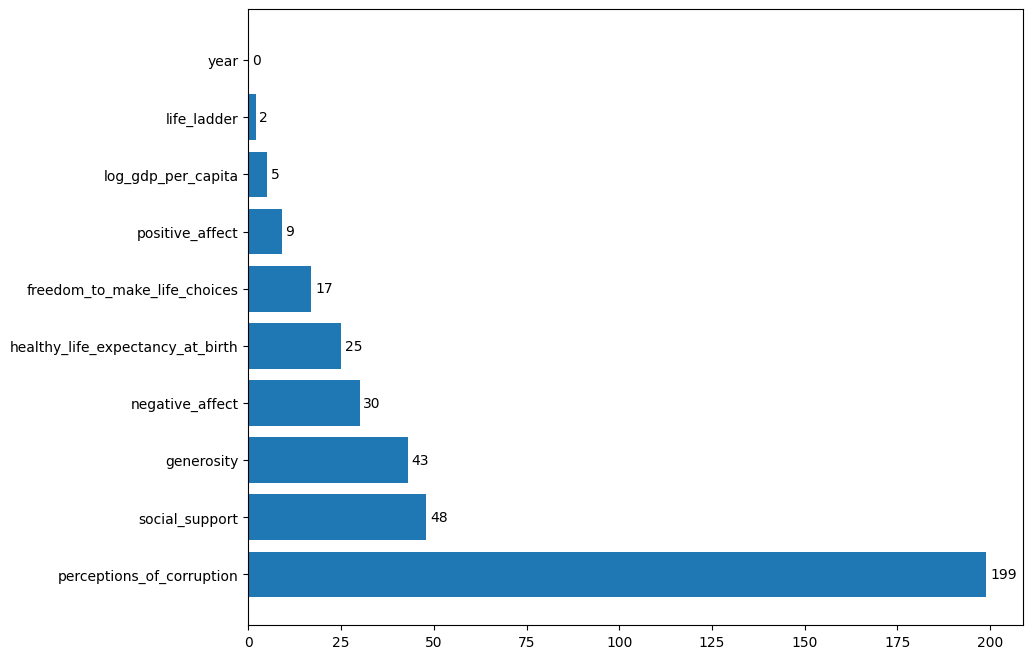

IQR outliers:::
Year: 0
Life ladder: 2
Log gdp per capita: 5
Social support: 48
Healthy life expectancy at birth: 25
Freedom to make life choices: 17
Generosity: 43
Perceptions of corruption: 199
Positive affect: 9
Negative affect: 30


In [36]:
num_cols = df.select_dtypes(include=np.number)

outlier_summary = {}

for col in num_cols.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outlier_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_summary[col] = outlier_count

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["outlier_count"]).sort_values("outlier_count", ascending=False)
plt.figure(figsize=(10,8))
plt.barh(outlier_df.index, outlier_df.outlier_count)

for i, v in enumerate(outlier_df.outlier_count):
    plt.text(v + 1, i, str(v), va="center")


plt.show()


print("IQR outliers:::")
for x in outlier_summary:
    print(f"{x.capitalize().replace("_", " ")}: {outlier_summary[x]}")

Here is another way to determine the outliers: The Z-score, though it usually useful when data is continuous.

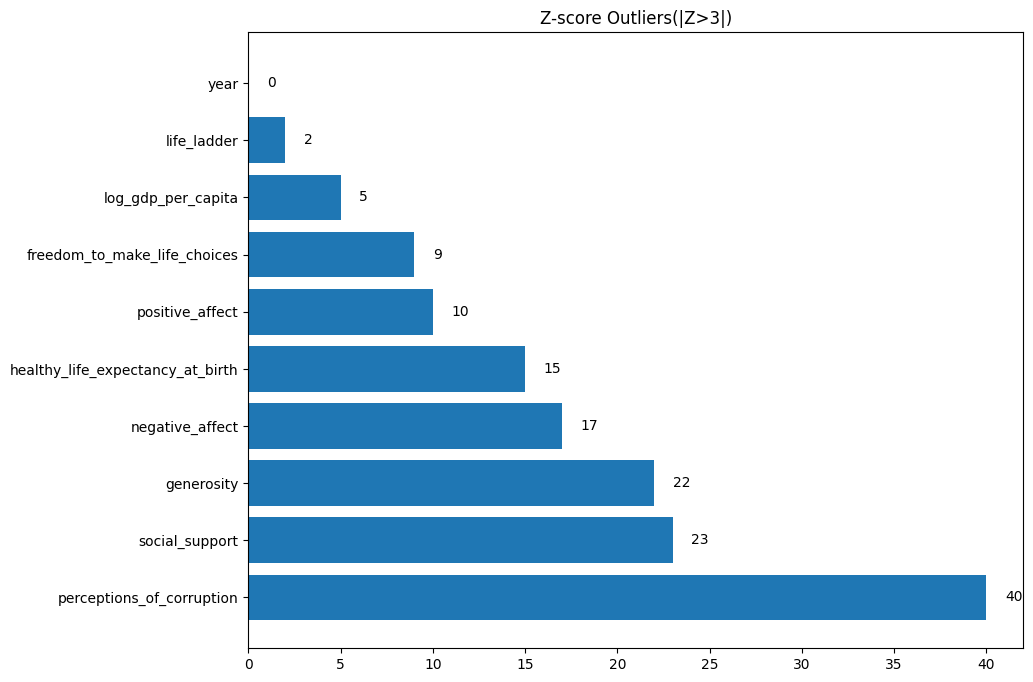

                                  outlier_count
perceptions_of_corruption                    40
social_support                               23
generosity                                   22
negative_affect                              17
healthy_life_expectancy_at_birth             15
positive_affect                              10
freedom_to_make_life_choices                  9
log_gdp_per_capita                            5
life_ladder                                   2
year                                          0


In [37]:
outlier_summary = {}

for col in num_cols.columns:
    z = zscore(df[col], nan_policy="omit")
    outlier_count = np.sum(np.abs(z) > 3)
    outlier_summary[col] = outlier_count

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["outlier_count"]).sort_values("outlier_count", ascending=False)
plt.figure(figsize=(10,8))
plt.barh(outlier_df.index, outlier_df.outlier_count)

for i, v in enumerate(outlier_df.outlier_count):
    plt.text(v + 1, i, str(v), va="center")

plt.title("Z-score Outliers(|Z>3|)")
plt.show()

print(outlier_df)

Correlation matrix

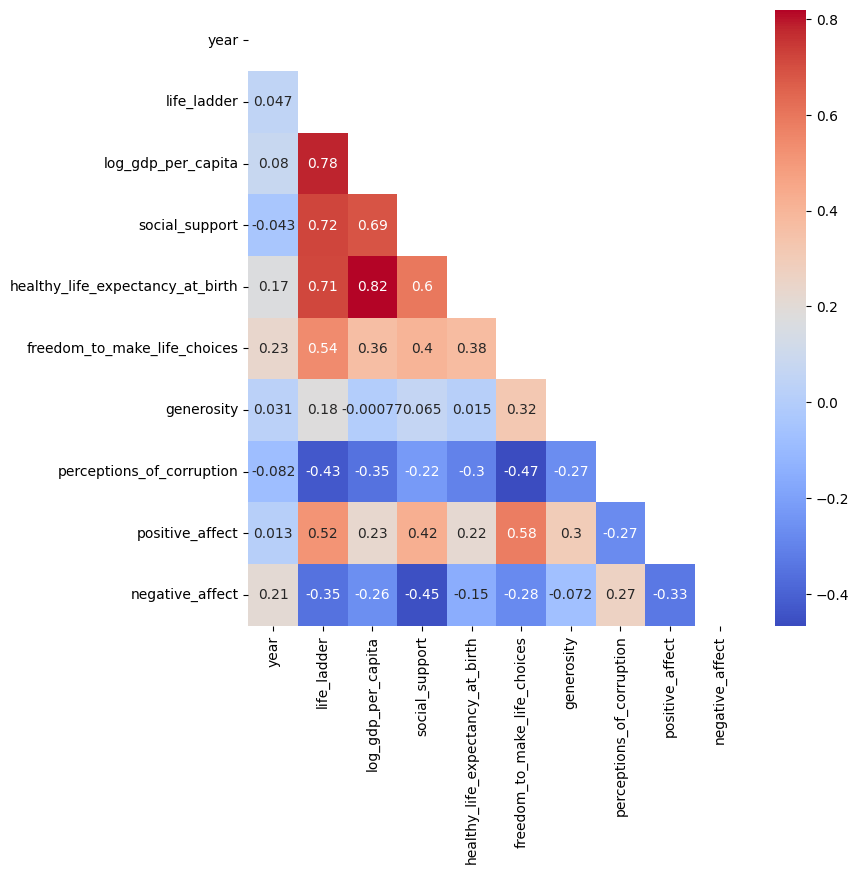

In [63]:
num_cols = df.select_dtypes(include=[np.number])
corr_matrix = num_cols.corr()
mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
l1 = corr_matrix.mask(mask)

plt.figure(figsize=(8,8))
sns.heatmap(data=corr_matrix, cmap="coolwarm", annot=True, mask = mask)

plt.show()


As shown in the correlation matrix:

* Happiness and Wealth: As a country gets richer (Log GDP per capita), people"s happiness levels (Life Ladder) increase very strongly (0.77 correlation).


* Health and Wealth: The strongest relationship in the dataset is between economic prosperity and healthy life expectancy; citizens of wealthy countries live significantly longer and healthier lives (0.81 correlation).


* Social Support and Happiness: Having someone to rely on during difficult times (Social Support) greatly increases overall life satisfaction (Life Ladder) (0.72 correlation).


* Freedom and Positive Emotions: Having the freedom to make choices about one"s life directly increases the positive emotions (joy, laughter, etc.) felt during the day (0.58 correlation).


* Corruption and Happiness: As the perception of corruption in a country increases, overall happiness levels and life satisfaction weakly decreases (-0.42 correlation).


* Generosity and Happiness: Surprisingly, there is a very weak relationship between generosity and overall happiness (Life Ladder), meaning that a generous society is not necessarily a happy one (0.17 correlation).


* Freedom and Wealth: As a country gets richer (Log GDP per capita), people"s sense of freedom to make choices about their own lives also increases. But it"s weakly correlated (0.36 correlation).


* Corruption and Freedom: In countries with high perceptions of corruption, people"s freedom to make choices about their own lives decreases (-0.46 correlation). 

Most and Least Rich Countries According to Log GDP

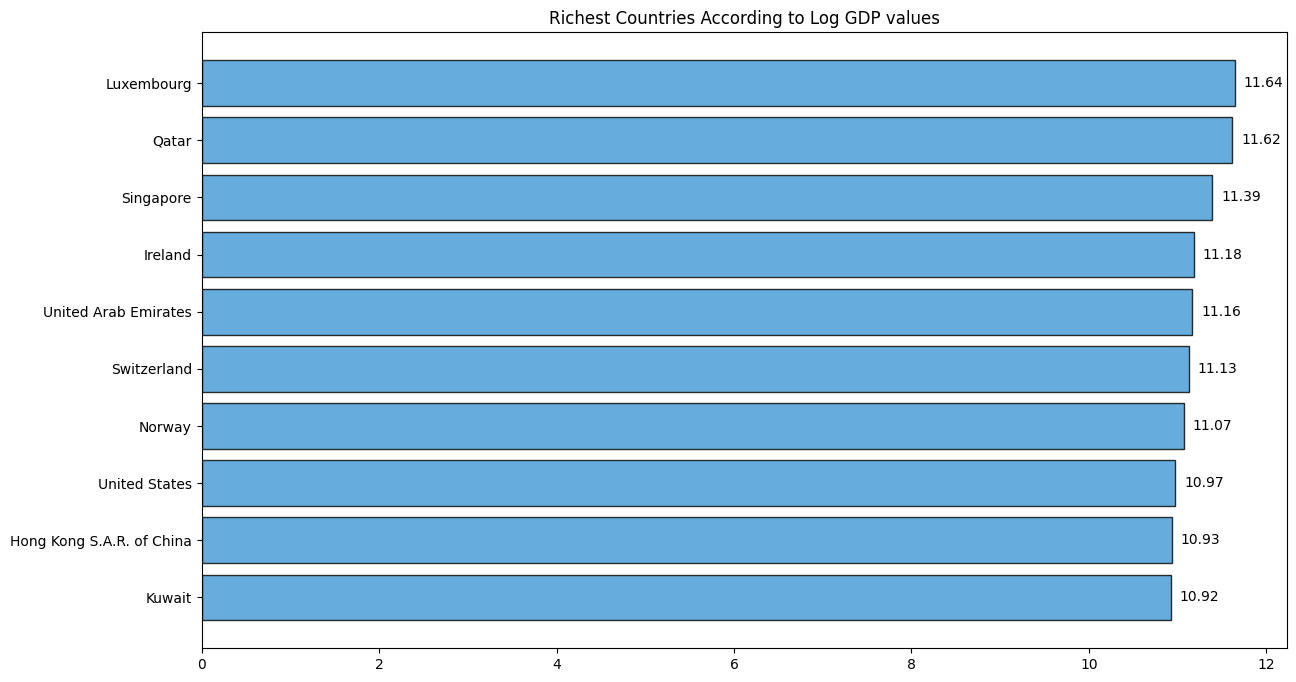

In [39]:
modded_df = df.groupby("country_name", as_index=False).median()

plot1 = modded_df[["country_name","log_gdp_per_capita"]]
plot1 = plot1.sort_values("log_gdp_per_capita", ascending=False)
topn = 10
topx = plot1.country_name.head(topn)
topy = plot1.log_gdp_per_capita.head(topn)

plt.figure(figsize=(14, 8))
plt.barh(topx, topy, color="#4097d4", edgecolor="black", alpha=0.8)
plt.gca().invert_yaxis()
for y, x in enumerate(topy):
    plt.annotate(f"{x:.2f}", xy=(x+0.1, y), va="center")
plt.title("Richest Countries According to Log GDP values")
plt.show()

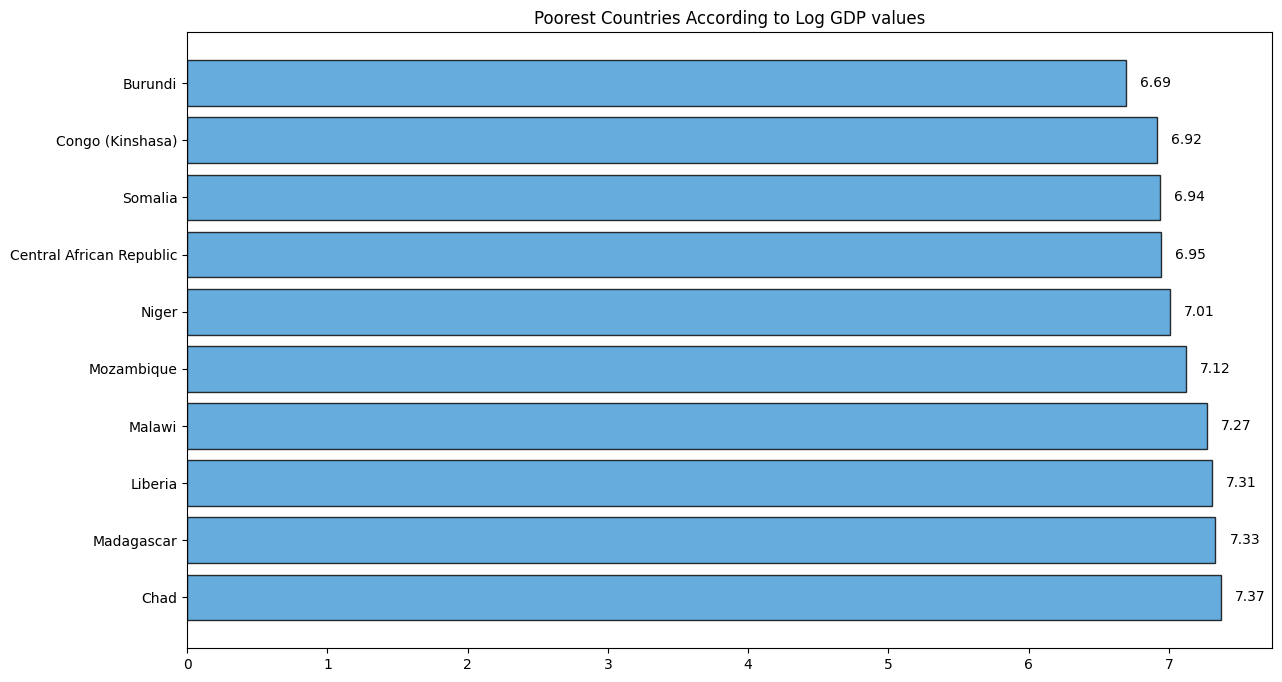

In [40]:
plot1 = modded_df[["country_name","log_gdp_per_capita"]]
plot1=plot1.sort_values("log_gdp_per_capita", ascending=True)
topn = 10
topx = plot1.country_name.head(topn)
topy = plot1.log_gdp_per_capita.head(topn)

plt.figure(figsize=(14, 8))
plt.barh(topx, topy, color="#4097d4", edgecolor="black", alpha=0.8)
plt.gca().invert_yaxis()
for y, x in enumerate(topy):
    plt.annotate(f"{x:.2f}", xy=(x+0.1, y), va="center")
plt.title("Poorest Countries According to Log GDP values")
plt.show()

There is a strong correlation between healthy life expectancy at birth and log GDP per capita (r = 0.81), so we visualized their relationship using a scatter plot. As shown in the plot, healthy life expectancy tends to increase as log GDP per increases.

We can add a trendline to better show the correlation

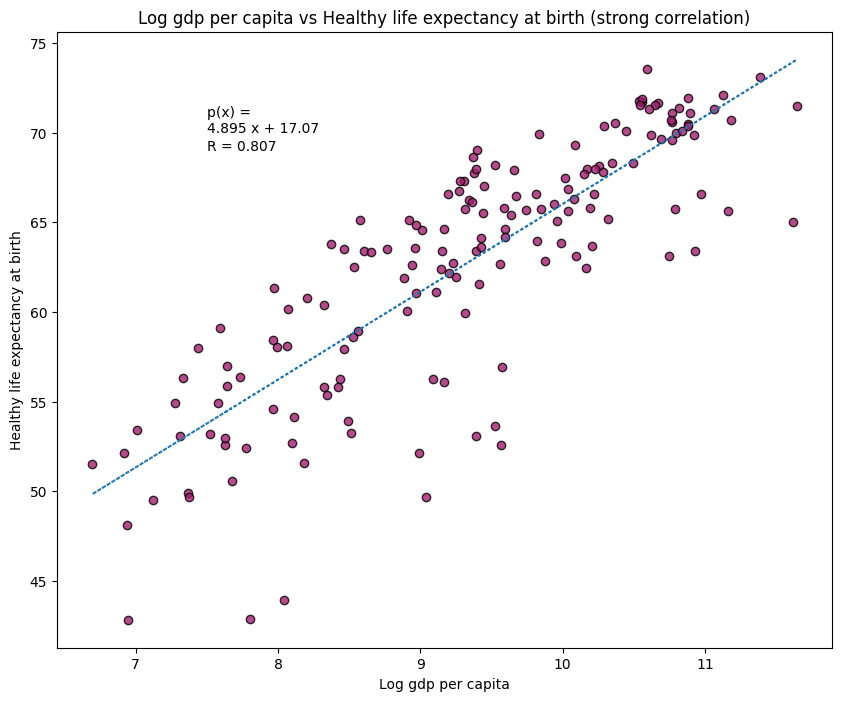

In [41]:
valid = modded_df[["log_gdp_per_capita", "healthy_life_expectancy_at_birth"]]

plt.figure(figsize=(10, 8))
plt.scatter(valid.log_gdp_per_capita, valid.healthy_life_expectancy_at_birth, color="#A41D70", edgecolor="black", alpha=0.8)
plt.ylabel("Healthy life expectancy at birth")
plt.xlabel("Log gdp per capita")
plt.title("Log gdp per capita vs Healthy life expectancy at birth (strong correlation)")

z = np.polyfit(valid.log_gdp_per_capita, valid.healthy_life_expectancy_at_birth, 1)
p = np.poly1d(z)

plt.plot(valid.log_gdp_per_capita, p(valid.log_gdp_per_capita),linestyle = "dotted")
plt.annotate(f"p(x) = {p}", (7.5,70))
plt.annotate(f"R = {l1.log_gdp_per_capita.healthy_life_expectancy_at_birth:.3f}", (7.5,69))

plt.show()


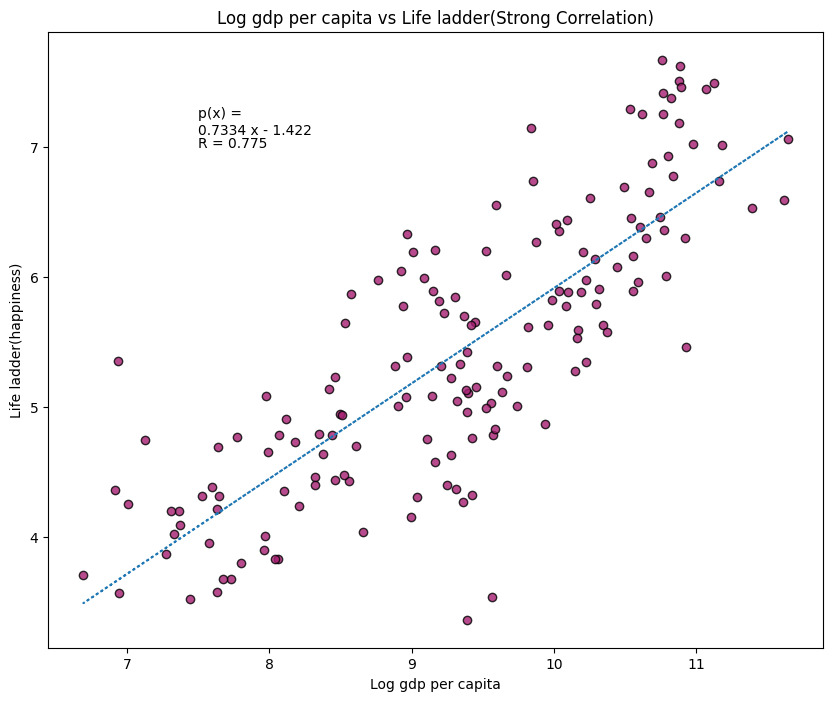

In [42]:
valid = modded_df[["log_gdp_per_capita", "life_ladder"]]

plt.figure(figsize=(10, 8))
plt.scatter(valid.log_gdp_per_capita, valid.life_ladder, color="#A41D70", edgecolor="black", alpha=0.8)
plt.ylabel("Life ladder(happiness)")
plt.xlabel("Log gdp per capita")
plt.title("Log gdp per capita vs Life ladder(Strong Correlation)")

z = np.polyfit(valid.log_gdp_per_capita, valid.life_ladder, 1)
p = np.poly1d(z)

plt.plot(valid.log_gdp_per_capita, p(valid.log_gdp_per_capita),linestyle = "dotted")
plt.annotate(f"p(x) = {p}", (7.5,7.1))
plt.annotate(f"R = {l1.life_ladder.log_gdp_per_capita:.3f}", (7.5,7))

plt.show()


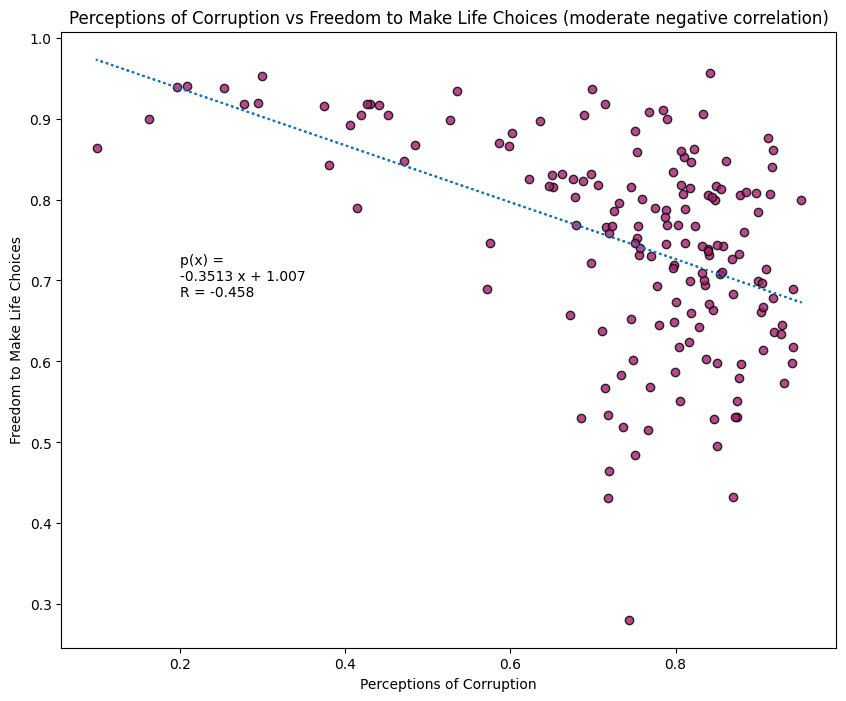

In [43]:
valid = modded_df[["perceptions_of_corruption", "freedom_to_make_life_choices"]]

plt.figure(figsize=(10, 8))
plt.scatter(valid.perceptions_of_corruption, valid.freedom_to_make_life_choices, color="#A41D70", edgecolor="black", alpha=0.8)
plt.ylabel("Freedom to Make Life Choices")
plt.xlabel("Perceptions of Corruption")
plt.title("Perceptions of Corruption vs Freedom to Make Life Choices (moderate negative correlation)")

z = np.polyfit(valid.perceptions_of_corruption, valid.freedom_to_make_life_choices, 1)
p = np.poly1d(z)

plt.plot(valid.perceptions_of_corruption, p(valid.perceptions_of_corruption),linestyle = "dotted")
plt.annotate(f"p(x) = {p}", (0.2,0.7))
plt.annotate(f"R = {l1.freedom_to_make_life_choices.perceptions_of_corruption:.3f}", (0.2,0.68))

plt.show()

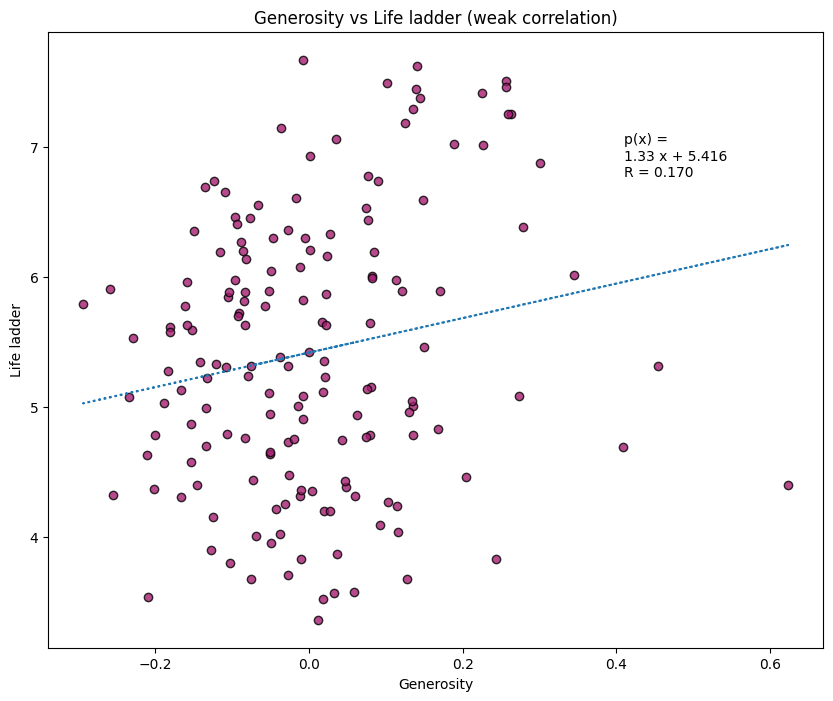

In [44]:
valid = modded_df[["generosity", "life_ladder"]]

plt.figure(figsize=(10, 8))
plt.scatter(valid.generosity, valid.life_ladder, color="#A41D70", edgecolor="black", alpha=0.8)
plt.ylabel("Life ladder")
plt.xlabel("Generosity")
plt.title("Generosity vs Life ladder (weak correlation)")

z = np.polyfit(valid.generosity, valid.life_ladder, 1)
p = np.poly1d(z)

plt.plot(valid.generosity, p(valid.generosity),linestyle = "dotted")
plt.annotate(f"p(x) = {p}", (0.41,6.9))
plt.annotate(f"R = {l1.life_ladder.generosity:.3f}", (0.41,6.77))

plt.show()

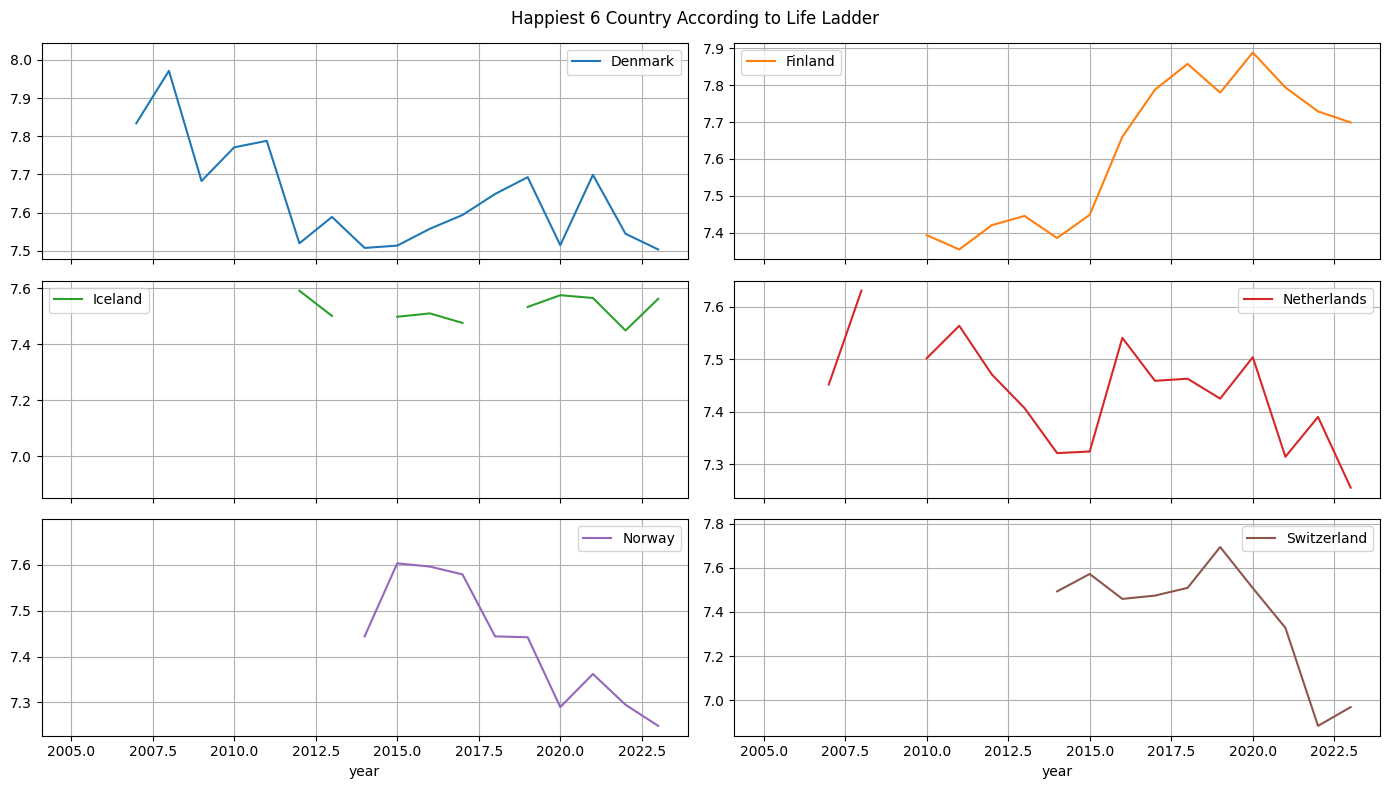

In [45]:
top_countries = df.groupby("country_name")["life_ladder"].mean().nlargest(6).index

df_filtered = df[df.country_name.isin(top_countries)]

df_pivot = df_filtered.pivot(index="year", columns="country_name", values="life_ladder")

df_pivot.plot(subplots=True, layout=(3, 2), figsize=(14, 8), title="Happiest 6 Country According to Life Ladder", sharex=True, grid=True)

plt.tight_layout()
plt.show()

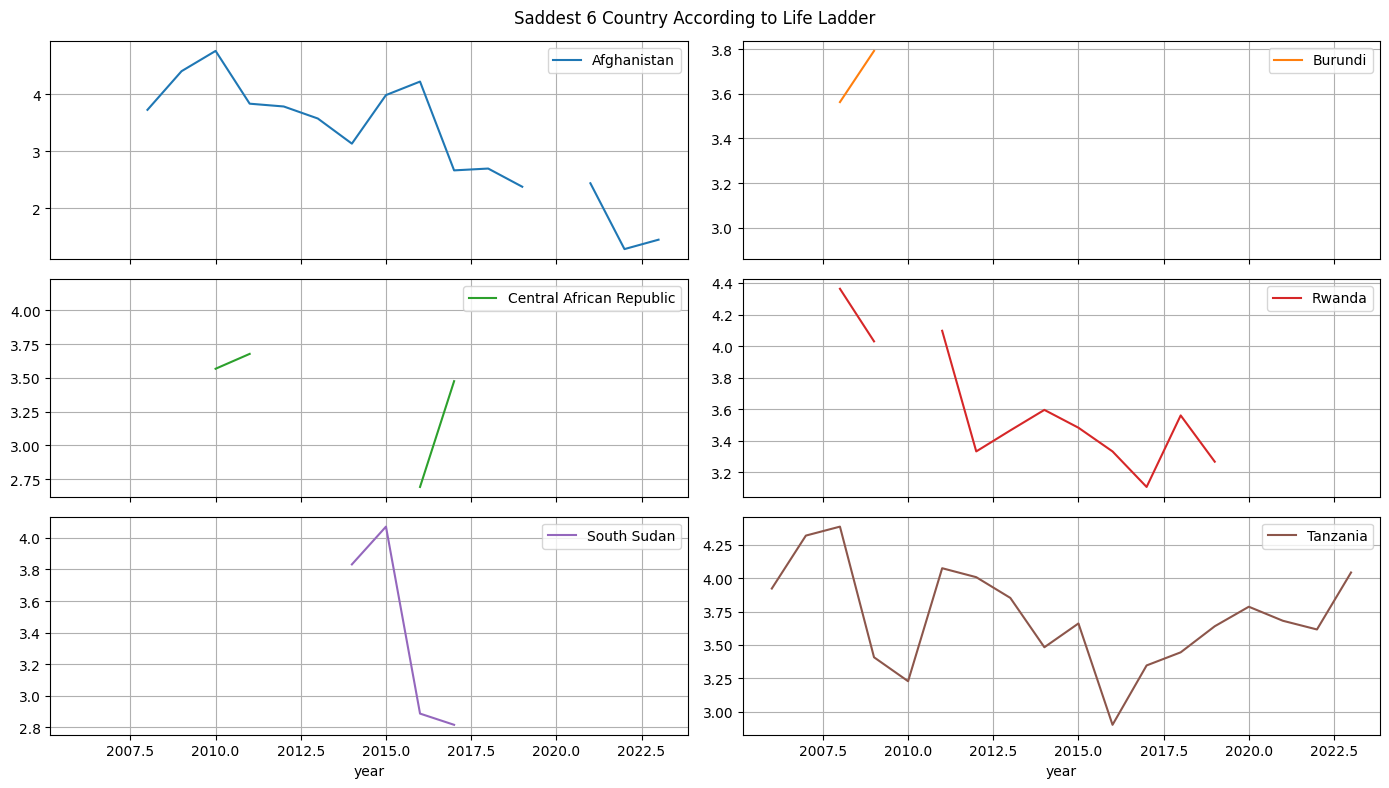

In [46]:
top_countries = df.groupby("country_name")["life_ladder"].mean().nsmallest(6).index

df_filtered = df[df.country_name.isin(top_countries)]

df_pivot = df_filtered.pivot(index="year", columns="country_name", values="life_ladder")

df_pivot.plot(subplots=True, layout=(3, 2), figsize=(14, 8), title="Saddest 6 Country According to Life Ladder", sharex=True, grid=True)

plt.tight_layout()
plt.show()

- The number of available data points for the countries analyzed is relatively small. Missing data for some years in the dataset may prevent the trend lines in the graphs from accurately reflecting the actual annual changes. 
- It should be noted that in time series created with a small number of observations(last graphs), a single outlier can dramatically affect the direction of the trend, and possible changes in years may remain invisible on the graph (interpolation effect). Therefore, the trends shown should be considered as a general idea rather than a 
trajectory.
- Missing data points (like Central African Republic graph) might distort the overall graph.

# Analysis of World-happiness-report-2024.csv

In [47]:
df2024 = pd.read_csv("data2.csv", encoding = "latin1")
df2024.columns = df2024.columns.str.lower().str.replace(" ","_")
df2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country_name                  143 non-null    object 
 1   regional_indicator            143 non-null    object 
 2   ladder_score                  143 non-null    float64
 3   upperwhisker                  143 non-null    float64
 4   lowerwhisker                  143 non-null    float64
 5   log_gdp_per_capita            140 non-null    float64
 6   social_support                140 non-null    float64
 7   healthy_life_expectancy       140 non-null    float64
 8   freedom_to_make_life_choices  140 non-null    float64
 9   generosity                    140 non-null    float64
 10  perceptions_of_corruption     140 non-null    float64
 11  dystopia_+_residual           140 non-null    float64
dtypes: float64(10), object(2)
memory usage: 13.5+ KB


In [48]:
df2024.head(10)

,country_name,regional_indicator,ladder_score,upperwhisker,lowerwhisker,log_gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,dystopia_+_residual
0,Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298
5,Netherlands,Western Europe,7.319,7.383,7.256,1.901,1.462,0.706,0.725,0.247,0.372,1.906
6,Norway,Western Europe,7.302,7.389,7.215,1.952,1.517,0.704,0.835,0.224,0.484,1.586
7,Luxembourg,Western Europe,7.122,7.213,7.031,2.141,1.355,0.708,0.801,0.146,0.432,1.540
8,Switzerland,Western Europe,7.060,7.147,6.973,1.970,1.425,0.747,0.759,0.173,0.498,1.488
9,Australia,North America and ANZ,7.057,7.141,6.973,1.854,1.461,0.692,0.756,0.225,0.323,1.745


In [49]:
df2024.isna().sum()

country_name                    0
regional_indicator              0
ladder_score                    0
upperwhisker                    0
lowerwhisker                    0
log_gdp_per_capita              3
social_support                  3
healthy_life_expectancy         3
freedom_to_make_life_choices    3
generosity                      3
perceptions_of_corruption       3
dystopia_+_residual             3
dtype: int64

In [50]:
df2024.describe()

,ladder_score,upperwhisker,lowerwhisker,log_gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,dystopia_+_residual
count,143.000000,143.000000,143.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,5.527580,5.641175,5.413972,1.378807,1.134329,0.520886,0.620621,0.146271,0.154121,1.575914
std,1.170717,1.155008,1.187133,0.425098,0.333317,0.164923,0.162492,0.073441,0.126238,0.537459
min,1.721000,1.775000,1.667000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.073000
25%,4.726000,4.845500,4.606000,1.077750,0.921750,0.398000,0.527500,0.091000,0.068750,1.308250
50%,5.785000,5.895000,5.674000,1.431500,1.237500,0.549500,0.641000,0.136500,0.120500,1.644500
75%,6.416000,6.507500,6.319000,1.741500,1.383250,0.648500,0.736000,0.192500,0.193750,1.881750
max,7.741000,7.815000,7.667000,2.141000,1.617000,0.857000,0.863000,0.401000,0.575000,2.998000


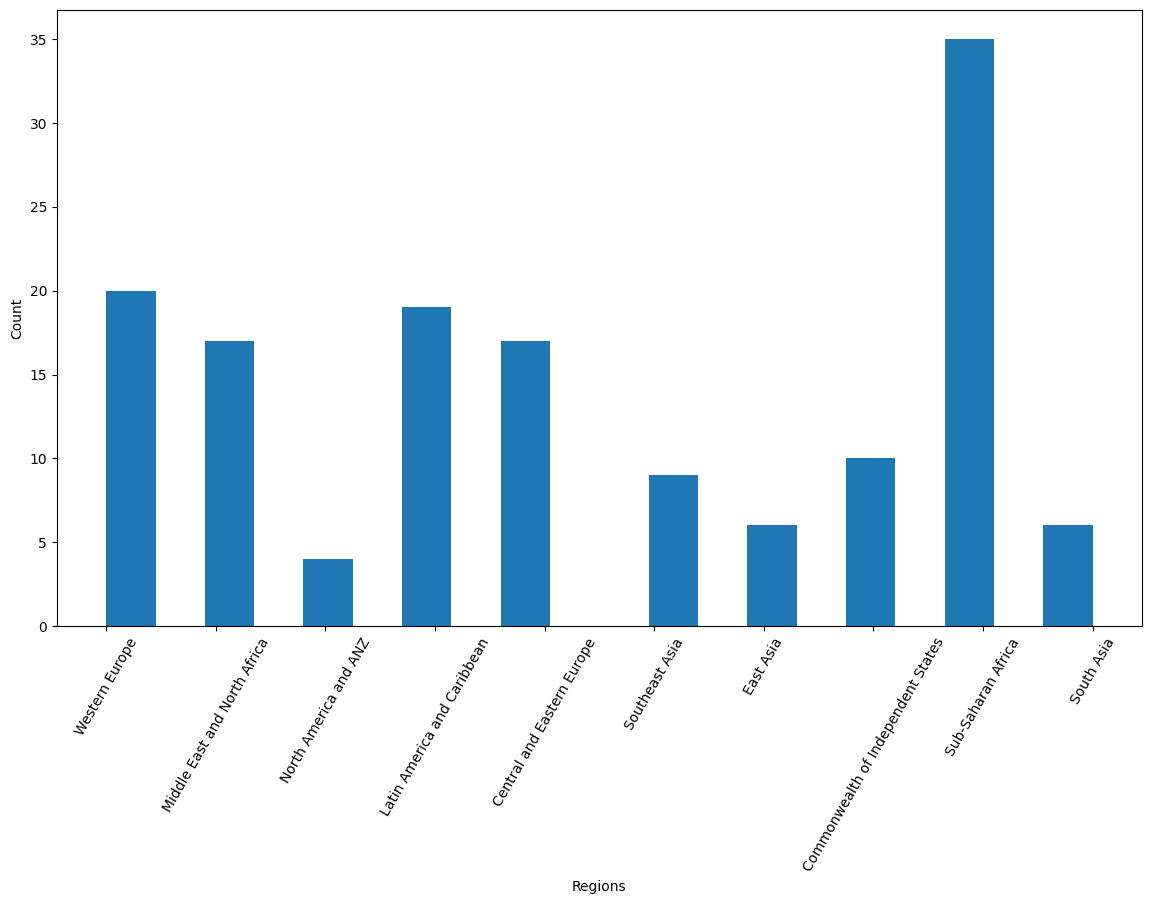

In [51]:
colors = ["aqua", "red", "gold", "royalblue", "darkorange", "green", "purple", "cyan", "yellow", "lime"]

plt.figure(figsize=(14,8))

plt.hist(x ="regional_indicator", data = df2024, bins=20)
plt.xticks(rotation = 60)
plt.ylabel("Count")
plt.xlabel("Regions")

plt.show()

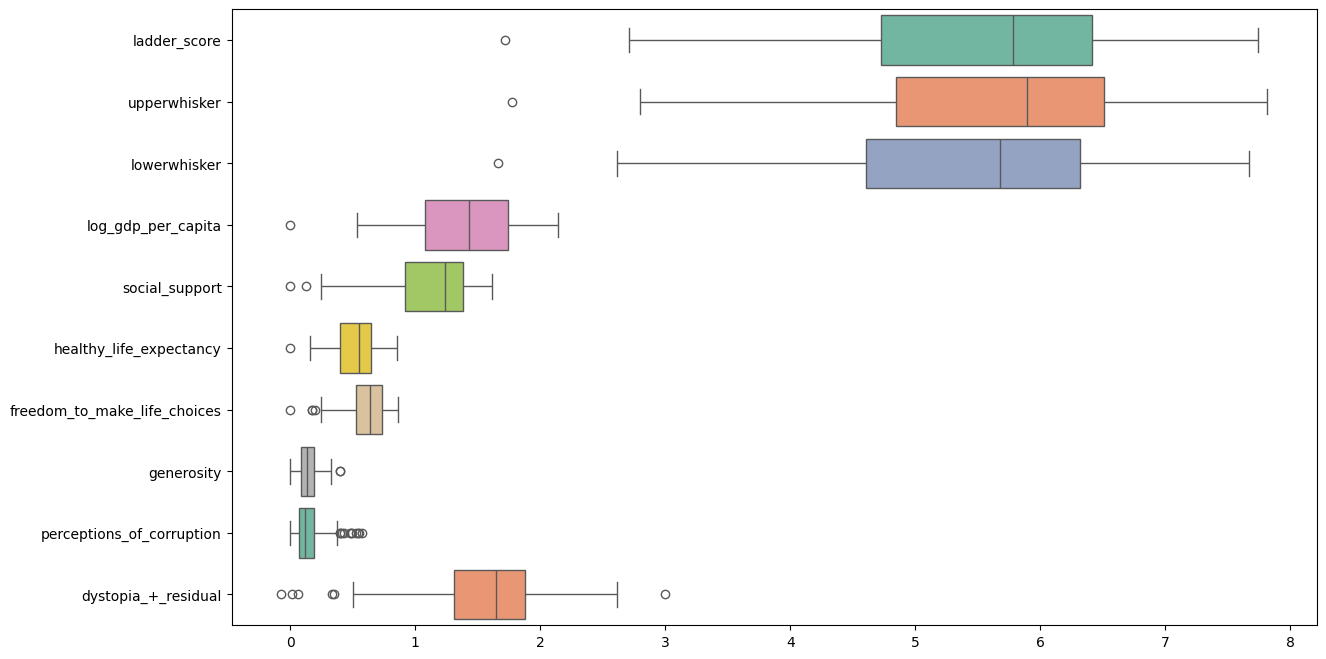

In [55]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df2024,orient="h",palette = "Set2")
plt.show()

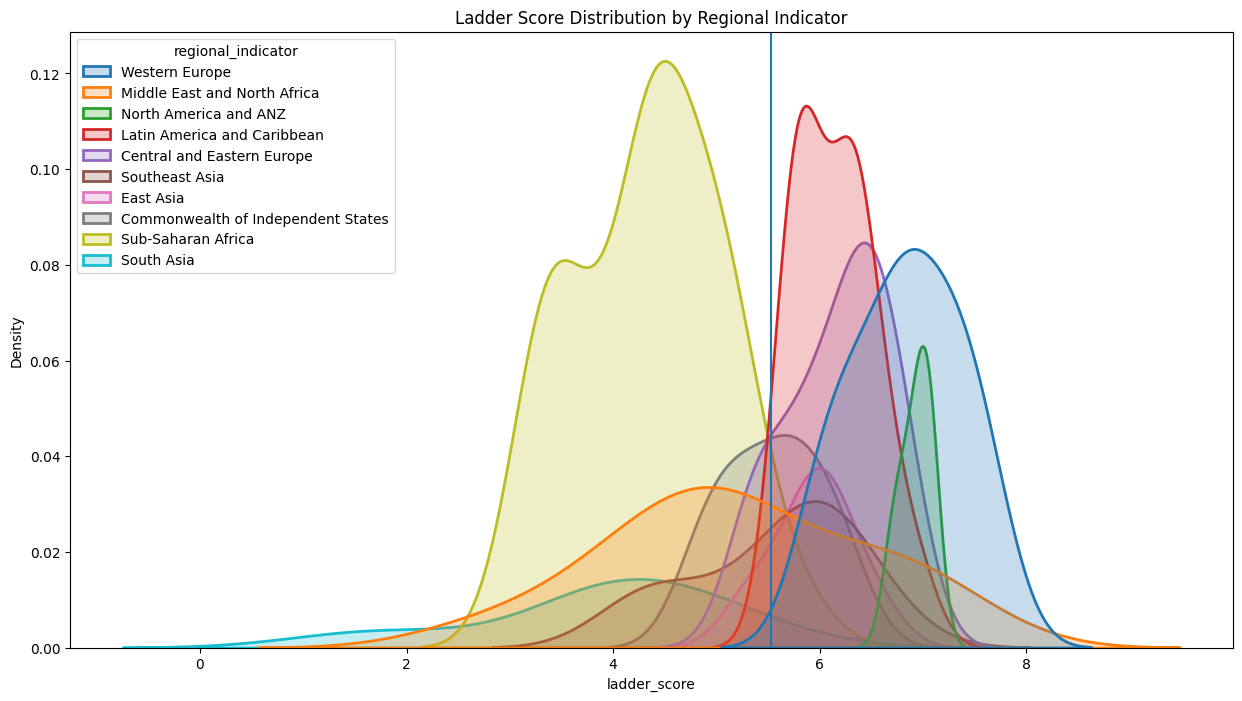

In [58]:
plt.figure(figsize = (15,8))
sns.kdeplot(x=df2024.ladder_score, hue = df2024.regional_indicator, fill = True, linewidth = 2)
plt.axvline(df2024.ladder_score.mean())
plt.title("Ladder Score Distribution by Regional Indicator")
plt.show()